In [9]:
import numpy as np 
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from spellchecker import SpellChecker
import enchant
import wordninja
from autocorrect import Speller

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping


### Data Collection

In [11]:
df = pd.read_csv("../../Datasets/sentiment_analysis/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df = df.drop(columns=["id"])
display(df.head(3))  

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."


### Data Train Test Slit

In [81]:
X = df[["review"]]
y = df[["sentiment"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

### Data Preprocessing - Including Lematisation and Tokenisation

In [82]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Carl\AppData\Roaming\nltk_data...
[nltk_

True

In [ ]:
stops = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [90]:
def data_preprocessing(text):

    # convert to lowercase
    text = text.lower()

    # remove special characters from head and tail of words
    text = ' '.join([re.sub(r'^[^\w]+|[^\w]+$', '', word) for word in text.split()])

    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in stops]) 

    # remove URLs
    text = re.sub(r'http\S+', '', text) # URLs

    # remove HTML tags
    text = re.sub(r'<.*?>', '', text) # HTML tags

    # remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text).rstrip()

    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # remove double spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    return text

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def build_vocabulary(texts_col, freq_threshold=1):
    word_freq = {}
    for text in texts_col:
        cleaned = data_preprocessing(text)
        lemmatised = lemmatize_text(cleaned)
        words = lemmatised.split()
        for word in words:
            word_freq[word] = word_freq.get(word, 0) + 1
    vocab = {}
    index = 1
    for word, freq in word_freq.items():
        if freq >= freq_threshold:
            vocab[word] = index
            index += 1
    return vocab

def data_tokenisation(text):
    return text.split()

def data_lemmatisation(seq):
    return [lemmatizer.lemmatize(word) for word in seq]

def text_to_sequence(text, vocab):
    cleaned = data_preprocessing(text)
    lemmatised = lemmatize_text(cleaned)
    words = lemmatised.split()
    return [vocab[word] for word in words if word in vocab]

def pad_sequences_custom(sequences, max_len):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            padded_seq = [0] * (max_len - len(seq)) + seq
        else:
            padded_seq = seq[-max_len:]  # take the last max_len tokens
        padded.append(padded_seq)
    return np.array(padded)

In [91]:
df_train["review_cleaned"] = df_train['review'].apply(data_preprocessing)

In [92]:
freq_threshold = 2  # Include words that appear at least n times (removes infrequent words)
vocab = build_vocabulary(df_train["review_cleaned"], freq_threshold=freq_threshold) 

In [93]:
sequences = [text_to_sequence(text, vocab) for text in df_train["review_cleaned"]] 

In [94]:
max_len = 150 # Maximum sequence length
padded_sequences = pad_sequences_custom(sequences, max_len=max_len)

In [95]:
padded_sequences

array([[   78,    45,    79, ...,   165,   166,   167],
       [    0,     0,     0, ...,   254,    68,   255],
       [    0,     0,     0, ...,   277,   262,   278],
       ...,
       [    0,     0,     0, ..., 16360,    50,  4010],
       [ 3104,  1239,  1894, ...,   495,   828,  1904],
       [    0,     0,     0, ...,   255,  4459,  2822]])

In [96]:
labels = np.array(df_train['sentiment'])
labels

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [100]:
def eval_model(history):
    
    # Extract the values for loss and accuracy from the history object.
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']

    # If you are using a validation split, you'll also have these metrics.
    val_loss = history.history.get('val_loss')
    val_accuracy = history.history.get('val_accuracy')

    # Get the number of epochs (for the x-axis of the plot).
    epochs = range(1, len(train_loss) + 1)

    # Plotting Training and Validation Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [98]:
embedding_dim = 50
lstm_units = 64
vocab_size = len(vocab) + 1  # +1 for the reserved padding index 0

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(padded_sequences, labels, epochs=10, batch_size=2, validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 357s 51ms/step - accuracy: 0.7073 - loss: 0.5586 - val_accuracy: 0.8591 - val_loss: 0.3422
Epoch 2/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 350s 50ms/step - accuracy: 0.9072 - loss: 0.2431 - val_accuracy: 0.8626 - val_loss: 0.3359
Epoch 3/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 349s 50ms/step - accuracy: 0.9641 - loss: 0.1070 - val_accuracy: 0.8689 - val_loss: 0.3164
Epoch 4/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 351s 50ms/step - accuracy: 0.9837 - loss: 0.0533 - val_accuracy: 0.8703 - val_loss: 0.4144
Epoch 5/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 350s 50ms/step - accuracy: 0.9941 - loss: 0.0226 - val_accuracy: 0.8580 - val_loss: 0.5074
Epoch 6/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 352s 50ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.8666 - val_loss: 0.6943
Epoch 7/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 378s 54ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.8506 - val_loss: 0.6370
Epoch 8/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 365s 52ms/step - accuracy: 

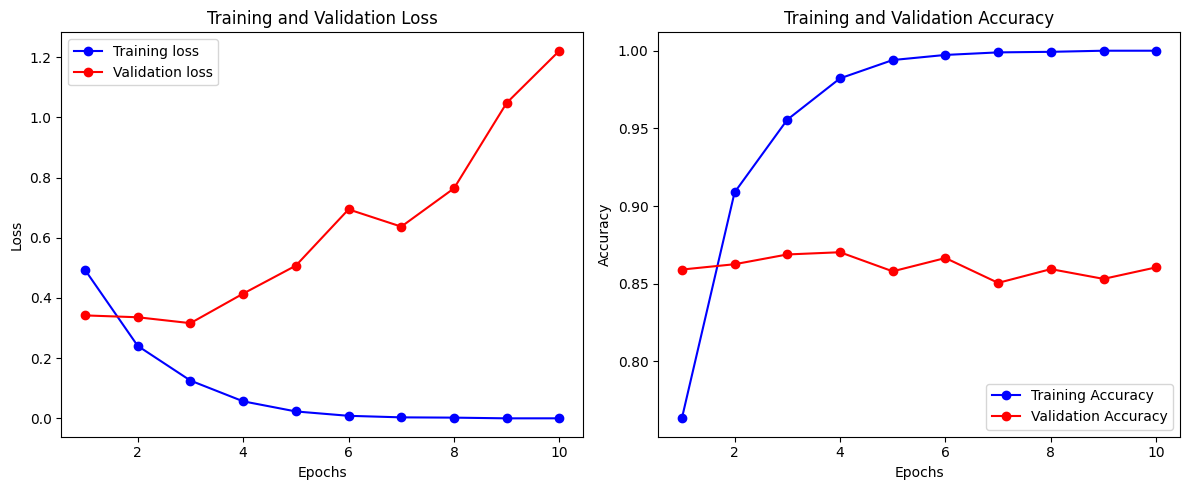

In [101]:
eval_model(history)

In [ ]:
embedding_dim = 50
lstm_units = 64
vocab_size = len(vocab) + 1  # +1 for the reserved padding index 0

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    padded_sequences, 
    labels, 
    epochs=30, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stop]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6680 - loss: 0.5889 - val_accuracy: 0.8691 - val_loss: 0.3129
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9358 - loss: 0.1815 - val_accuracy: 0.8743 - val_loss: 0.3568
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9773 - loss: 0.0771 - val_accuracy: 0.8691 - val_loss: 0.3907
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9897 - loss: 0.0364 - val_accuracy: 0.8660 - val_loss: 0.5082


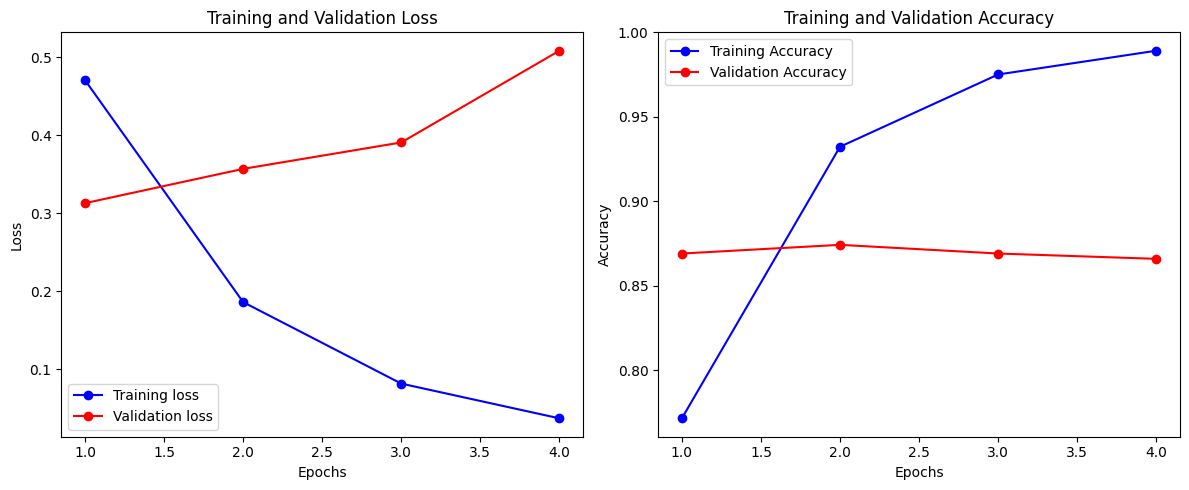

In [105]:
eval_model(history)

In [ ]:
embedding_dim = 50
lstm_units = 64
vocab_size = len(vocab) + 1  # +1 for the reserved padding index 0

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    padded_sequences, 
    labels, 
    epochs=30, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stop]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.6358 - loss: 0.6128 - val_accuracy: 0.8580 - val_loss: 0.3481
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9062 - loss: 0.2545 - val_accuracy: 0.8489 - val_loss: 0.3460
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9500 - loss: 0.1560 - val_accuracy: 0.8654 - val_loss: 0.4423
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.9691 - loss: 0.1006 - val_accuracy: 0.8540 - val_loss: 0.4351
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.9816 - loss: 0.0672 - val_accuracy: 0.8340 - val_loss: 0.5280


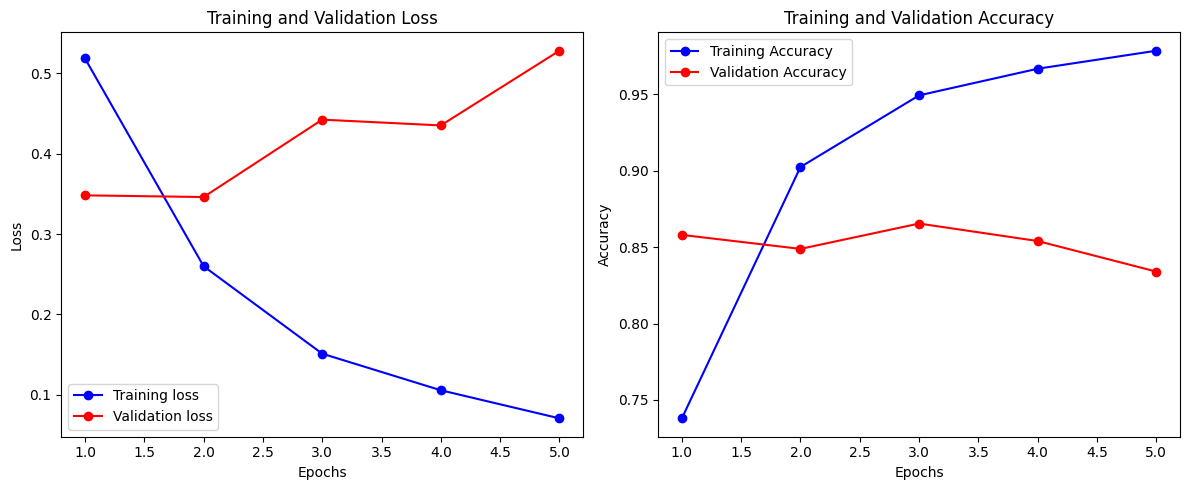

In [107]:
eval_model(history)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 299ms/step - accuracy: 0.6057 - loss: 0.6264 - val_accuracy: 0.8511 - val_loss: 0.3467
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 61s 280ms/step - accuracy: 0.8990 - loss: 0.2759 - val_accuracy: 0.8597 - val_loss: 0.3460
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 62s 282ms/step - accuracy: 0.9472 - loss: 0.1627 - val_accuracy: 0.8443 - val_loss: 0.4529
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 268ms/step - accuracy: 0.9626 - loss: 0.1140 - val_accuracy: 0.8563 - val_loss: 0.4725
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 60s 275ms/step - accuracy: 0.9813 - loss: 0.0642 - val_accuracy: 0.8423 - val_loss: 0.5418


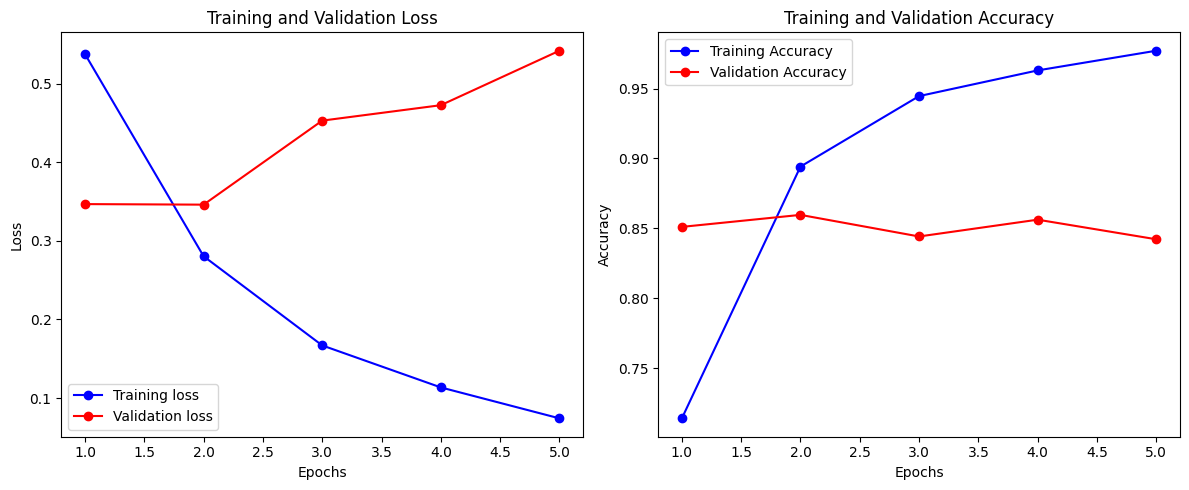

In [108]:
embedding_dim = 50
lstm_units = 64
vocab_size = len(vocab) + 1  # +1 for the reserved padding index 0

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.3)),
    Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    padded_sequences, 
    labels, 
    epochs=30, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stop]
)

eval_model(history)